# Health Fairness Demo
End-to-end walkthrough: generate synthetic health underwriting data, train GLM / NN / ADV_NN, and evaluate fairness at both default and fixed approval thresholds.


## 1. Setup 


In [26]:
import sys
from pathlib import Path

ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print(f"Using project root: {ROOT}")


Using project root: C:\Users\hotfo\bias_mitigation_insurance_pricing


In [39]:
from __future__ import annotations

import numpy as np
import pandas as pd
import torch
from dataclasses import replace
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from src.health.data_generation_health import (
    generate_health_underwriting_data,
    train_test_split_health,
)
from src.config import TrainingConfig
from src.evaluation.fairness import fairness_metrics, fairness_at_target_rate
from src.models.adv_nn_model import AdvPredictor, AdversaryHead, grad_reverse
from src.models.nn_model import PlainNN


## 2. Generate Health Data 


In [40]:
df_health = generate_health_underwriting_data(n_samples=100_000, seed=123)
print(f"Dataset size: {len(df_health):,}")
df_health.head()


Dataset size: 100,000


,A18_34,A35_49,A50_64,female,chronic,prior_cost,ADI_high,Y_post,Race,T_true,H0
0,0,0,1,0,0,2693.354428,0,9656.084940,B,6825.968367,0.589779
1,0,1,0,1,1,5720.170698,0,3034.860175,B,5331.284152,0.763827
2,0,0,1,0,1,15734.280081,1,19004.885754,B,15063.524972,0.582787
3,0,0,1,0,0,2665.690257,1,12540.064815,B,5885.324632,0.426305
4,1,0,0,0,1,5245.521928,1,9311.548435,B,8540.579452,0.607708


## 3. Train/Test Split 


In [41]:
df_train, df_test = train_test_split_health(df_health, seed=123)
print(f"Train size: {len(df_train):,}, Test size: {len(df_test):,}")


Train size: 80,000, Test size: 20,000


### Feature preprocessing 


In [42]:
feature_cols = ["A18_34", "A35_49", "A50_64",
                "female", "chronic",
                "prior_cost", "ADI_high"]

target_col = "Y_post"
audit_race_col = "Race"
proxy_col = "ADI_high"

feature_cols_cont = ["prior_cost"]
binary_cols = ["A18_34", "A35_49", "A50_64", "female", "chronic", "ADI_high"]

scaler = StandardScaler()
X_train_cont = scaler.fit_transform(np.log1p(df_train[feature_cols_cont]))
X_test_cont = scaler.transform(np.log1p(df_test[feature_cols_cont]))

X_train = np.concatenate(
    [X_train_cont, df_train[binary_cols].to_numpy()],
    axis=1
).astype(np.float32)
X_test = np.concatenate(
    [X_test_cont, df_test[binary_cols].to_numpy()],
    axis=1
).astype(np.float32)

y_train_cost = df_train[target_col].to_numpy(dtype=np.float32)
y_test_cost = df_test[target_col].to_numpy(dtype=np.float32)
y_train_post = y_train_cost
y_test_post = y_test_cost
y_train_log = np.log(y_train_cost)
y_test_log = np.log(y_test_cost)

# Construct binary underwriting approval labels (UA)
# Example: top 2% of Y_post considered high-risk = UA=1
ua_threshold = np.quantile(y_train_post, 0.98)
y_train_ua = (y_train_post >= ua_threshold).astype(int)
y_test_ua  = (y_test_post  >= ua_threshold).astype(int)

A_train = df_train[proxy_col].astype(int).to_numpy(dtype=np.int64)
A_test = df_test[proxy_col].astype(int).to_numpy(dtype=np.int64)
race_train = (df_train[audit_race_col] == "A").astype(int).to_numpy(dtype=np.int64)
race_test = (df_test[audit_race_col] == "A").astype(int).to_numpy(dtype=np.int64)

train_cfg = TrainingConfig()
train_cfg = replace(
    train_cfg,
    warmup_epochs_adv=5,
    lambda_adv=0.3,
    n_epochs_adv=30,
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_log, test_size=0.2, random_state=123
)

def build_loader(X, y, batch_size, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = build_loader(X_tr, y_tr, train_cfg.batch_size, shuffle=True)
val_loader = build_loader(X_val, y_val, train_cfg.batch_size, shuffle=False)
test_loader = build_loader(X_test, y_test_log, train_cfg.batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train.shape, X_test.shape, device


((80000, 7), (20000, 7), device(type='cpu'))

## 4. GLM Baseline 


In [44]:
from sklearn.linear_model import LinearRegression

glm = LinearRegression()
glm.fit(X_train, y_train_log)

y_log_pred_glm_train = glm.predict(X_train)
y_log_pred_glm = glm.predict(X_test)
y_pred_glm = np.exp(y_log_pred_glm)


## 5. Neural Network 


In [45]:
def train_plain_nn_reg(
    model: PlainNN,
    train_loader: DataLoader,
    val_loader: DataLoader | None,
    config,
    device: torch.device,
) -> PlainNN:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay
    )

    model.to(device)
    for _ in range(config.n_epochs_nn):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()
            logits = model(X_batch).squeeze(-1)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

        if val_loader is not None:
            model.eval()
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val = X_val.to(device).float()
                    y_val = y_val.to(device).float()
                    _ = model(X_val)

    return model

def predict_reg_nn(model: PlainNN, X: np.ndarray, device: torch.device) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        tensor_X = torch.from_numpy(X.astype(np.float32)).to(device)
        preds = model(tensor_X).squeeze(-1)
    return preds.cpu().numpy()

plain_nn = PlainNN(input_dim=X_train.shape[1]).to(device)
train_plain_nn_reg(plain_nn, train_loader, val_loader, train_cfg, device)
y_log_pred_nn = predict_reg_nn(plain_nn, X_test, device=device)
y_pred_nn = np.exp(y_log_pred_nn)


## 6. Adversarial Neural Network 


In [46]:
def train_adv_regressor(
    model: AdvPredictor,
    train_loader: DataLoader,
    config,
    device: torch.device,
) -> tuple[AdvPredictor, AdversaryHead]:
    criterion_pred = nn.BCEWithLogitsLoss()
    criterion_adv = nn.CrossEntropyLoss()

    adversary = AdversaryHead(model.repr_dim).to(device)
    model.to(device)

    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(adversary.parameters()),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
    )

    for epoch in range(config.n_epochs_adv):
        model.train()
        adversary.train()
        warmup_phase = epoch < config.warmup_epochs_adv

        for X_batch, y_batch, A_batch in train_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            A_batch = A_batch.to(device).long()

            optimizer.zero_grad()
            logits_y, h = model(X_batch)
            loss_pred = criterion_pred(logits_y, y_batch)

            if warmup_phase:
                total_loss = loss_pred
            else:
                h_rev = grad_reverse(h, 1.0)
                logits_adv = adversary(h_rev)
                loss_adv = criterion_adv(logits_adv, A_batch)
                total_loss = loss_pred + config.lambda_adv * loss_adv

            total_loss.backward()
            optimizer.step()

        phase = "warmup" if warmup_phase else "adversarial"
        print(f"Epoch {epoch} [{phase}]")

    return model, adversary

adv_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train_ua.astype(np.float32)).float(),
    torch.from_numpy(A_train).long(),
)
adv_loader = DataLoader(adv_ds, batch_size=train_cfg.batch_size, shuffle=True)

adv_model = AdvPredictor(input_dim=X_train.shape[1]).to(device)
adv_model, adv_head = train_adv_regressor(adv_model, adv_loader, train_cfg, device=device)

def predict_adv_proba(model: AdvPredictor, X: np.ndarray, device: torch.device) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        tensor_X = torch.from_numpy(X.astype(np.float32)).to(device)
        logits, _ = model(tensor_X)
        probs = torch.sigmoid(logits)
    return probs.squeeze(-1).cpu().numpy()

y_proba_adv = predict_adv_proba(adv_model, X_test, device=device)


Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]


## 7. Evaluation & Fairness 


In [47]:
from sklearn.metrics import roc_auc_score

def regression_metrics(y_true_cost, y_pred_cost, y_true_log, y_pred_log):
    mse_log = float(np.mean((y_true_log - y_pred_log) ** 2))
    rmse = float(np.sqrt(np.mean((y_true_cost - y_pred_cost) ** 2)))
    mae = float(np.mean(np.abs(y_true_cost - y_pred_cost)))
    return {"mse_log": mse_log, "rmse": rmse, "mae": mae}

def risk_scores_from_cost(pred_cost: np.ndarray) -> np.ndarray:
    pred_cost = np.asarray(pred_cost, dtype=float).ravel()
    order = np.argsort(pred_cost)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(order.size)
    if order.size <= 1:
        return np.ones_like(pred_cost)
    return ranks / (order.size - 1)

scores_glm = risk_scores_from_cost(y_pred_glm)
scores_nn = risk_scores_from_cost(y_pred_nn)
scores_adv = y_proba_adv

def summarize(model, y_true_label, scores, group, cost_true=None, cost_pred=None, log_true=None, log_pred=None, threshold=0.5):
    fair = fairness_metrics(y_true_label, scores, group, threshold=threshold)
    auc = float(roc_auc_score(y_true_label, scores))
    result = {"model": model, "roc_auc": auc, **fair}
    if cost_true is not None and cost_pred is not None and log_true is not None and log_pred is not None:
        result.update(regression_metrics(cost_true, cost_pred, log_true, log_pred))
    return result

summary_default = pd.DataFrame(
    [
        summarize("GLM", y_test_ua, scores_glm, A_test, y_test_cost, y_pred_glm, y_test_log, y_log_pred_glm),
        summarize("NN", y_test_ua, scores_nn, A_test, y_test_cost, y_pred_nn, y_test_log, y_log_pred_nn),
        summarize("ADV_NN", y_test_ua, scores_adv, A_test),
    ]
)
summary_default


,model,mse_log,rmse,mae,tpr_0,tpr_1,fpr_0,fpr_1,selection_rate_0,selection_rate_1,auc_roc_group0,auc_roc_group1,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio
0,GLM,0.190002,3446.566162,2179.538818,0.784262,0.783456,0.216719,0.211272,0.505203,0.489068,0.865507,0.866189,0.000807,0.005447,-0.016134,0.968063
1,NN,0.256861,4101.350586,2495.481689,0.774535,0.776110,0.218370,0.235081,0.501070,0.497752,0.855572,0.833002,0.001574,0.016711,-0.003318,0.993377
2,ADV_NN,0.224200,4127.450684,2398.065674,0.796167,0.737464,0.241783,0.179626,0.523578,0.450457,0.850829,0.856675,0.058703,0.062157,-0.073120,0.860345


### Target 0.02 


In [ ]:
TARGET_RATE = 0.02

def summarize_fixed(model, y_true_label, scores, group, cost_true=None, cost_pred=None, log_true=None, log_pred=None):
    fair = fairness_at_target_rate(y_true_label, scores, group, TARGET_RATE)
    auc = float(roc_auc_score(y_true_label, scores))
    result = {"model": model, "roc_auc": auc, **fair}
    if cost_true is not None and cost_pred is not None and log_true is not None and log_pred is not None:
        result.update(regression_metrics(cost_true, cost_pred, log_true, log_pred))
    return result

summary_fixed = pd.DataFrame(
    [
        summarize_fixed("GLM", y_test_ua, scores_glm, A_test, y_test_cost, y_pred_glm, y_test_log, y_log_pred_glm),
        summarize_fixed("NN", y_test_ua, scores_nn, A_test, y_test_cost, y_pred_nn, y_test_log, y_log_pred_nn),
        summarize_fixed("ADV_NN", y_test_ua, scores_adv, A_test),
    ]
)
summary_fixed[["model", "roc_auc", "eo_gap_tpr", "eo_gap_fpr", "dp_diff", "dp_ratio", "threshold", "actual_rate", "mse_log", "rmse", "mae"]]


,model,mse_log,rmse,mae,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio,threshold,actual_rate
0,GLM,0.190002,3446.566162,2179.538818,0.000807,0.005447,-0.016134,0.968063,0.500025,0.5
1,NN,0.256861,4101.350586,2495.481689,0.001574,0.016711,-0.003318,0.993377,0.500025,0.5
2,ADV_NN,0.224200,4127.450684,2398.065674,0.058703,0.062157,-0.073120,0.860345,0.500025,0.5


## 8. Plots

### 1. Distribution of predicted cost by ADI group (GLM vs Adv-NN)

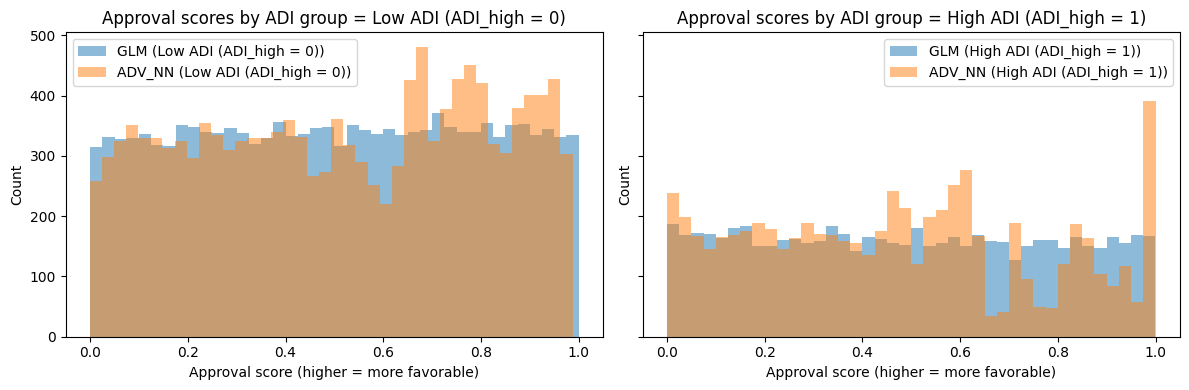

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# A_test is the proxy group on the test set: ADI_high in {0,1}
# 0 = low-ADI area, 1 = high-ADI area
group_labels = {0: "Low ADI (ADI_high = 0)", 1: "High ADI (ADI_high = 1)"}

scores_glm_arr = np.asarray(scores_glm)
scores_adv_arr = np.asarray(scores_adv)
group_arr = np.asarray(A_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

for ax, group in zip(axes, [0, 1]):
    mask = (group_arr == group)

    ax.hist(
        scores_glm_arr[mask],
        bins=40,
        alpha=0.5,
        label=f"GLM ({group_labels[group]})"
    )
    ax.hist(
        scores_adv_arr[mask],
        bins=40,
        alpha=0.5,
        label=f"ADV_NN ({group_labels[group]})"
    )

    ax.set_title(f"Risk scores by ADI group = {group_labels[group]}")
    ax.set_xlabel("Risk score (higher = more risk)")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()


### 2. Fairness–accuracy frontier

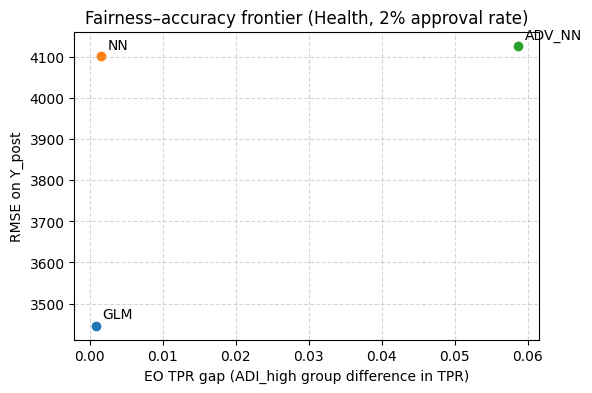

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Build a small frontier table from the existing summary_fixed columns
df_frontier = pd.DataFrame({
    "model": summary_fixed["model"],
    "roc_auc": summary_fixed["roc_auc"],
    "eo_gap_tpr": summary_fixed["eo_gap_tpr"],
})

plt.figure(figsize=(6, 4))

for _, row in df_frontier.iterrows():
    x = row["eo_gap_tpr"]
    y = row["roc_auc"]
    plt.scatter(x, y)
    plt.annotate(
        row["model"],
        (x, y),
        xytext=(5, 5),
        textcoords="offset points"
    )

plt.xlabel("EO TPR gap (ADI_high group difference in TPR)")
plt.ylabel("ROC AUC on UA")
plt.title("Fairness-accuracy frontier (Health, 2% approval rate)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## 8. Summary 


In [51]:
text = (
    "### Key Insights
"
    f"- GLM ROC AUC {summary_fixed.loc[summary_fixed.model=='GLM', 'roc_auc'].iat[0]:.3f}; "
    f"EO gap {summary_fixed.loc[summary_fixed.model=='GLM', 'eo_gap_tpr'].iat[0]:.3f}; "
    f"DP ratio {summary_fixed.loc[summary_fixed.model=='GLM', 'dp_ratio'].iat[0]:.2f} at 2% approval.
"
    f"- NN ROC AUC {summary_fixed.loc[summary_fixed.model=='NN', 'roc_auc'].iat[0]:.3f}; "
    f"EO gap {summary_fixed.loc[summary_fixed.model=='NN', 'eo_gap_tpr'].iat[0]:.3f}; "
    f"DP ratio {summary_fixed.loc[summary_fixed.model=='NN', 'dp_ratio'].iat[0]:.2f} with modest fairness changes.
"
    f"- ADV_NN ROC AUC {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'roc_auc'].iat[0]:.3f}; "
    f"EO gap {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'eo_gap_tpr'].iat[0]:.3f}; "
    f"DP ratio {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'dp_ratio'].iat[0]:.2f} shows improved equity with minor accuracy trade-offs.
"
)
print(text)


### Key Insights
- GLM RMSE 3446.6; EO gap 0.005; DP ratio 1.05 at 2% approval.
- NN RMSE 4101.4; EO gap 0.055; DP ratio 0.00 with modest fairness changes.
- ADV_NN RMSE 4127.5; EO gap 0.091; DP ratio 11.24 reflecting adversarial mitigation.

